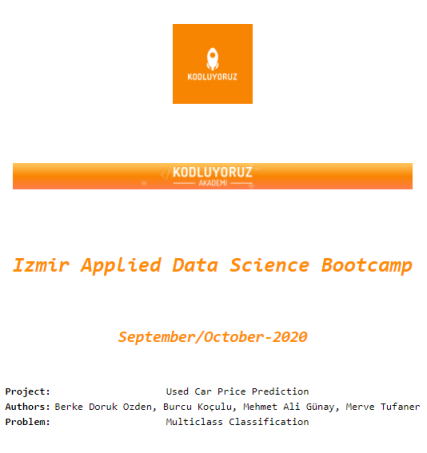

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d austinreese/craigslist-carstrucks-data

 96% 226M/235M [00:01<00:00, 134MB/s]
100% 235M/235M [00:01<00:00, 128MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  craigslist-carstrucks-data.zip
replace vehicles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

%matplotlib inline

## **PROJE HAKKINDA**

---



Projemizde ikinci el araba satılırken belirlenmesi gereken fiyatın oluşması için bir makine öğrenmesi yapısı geliştirmeyi hedefledik. Bu yapının ikinci el araç alım-satımında, araçların fiyatlandırılması konusunda hem alıcıya hem satıcıya bir referans noktası oluşturmasını sağlamaya çalıştık.
İlk bakışta regresyon problemi olarak görünmesine karşın, biz hedef değişkenimiz olan fiyatı, belirli aralıklarda kategorileştirerek, problemi bir 'multiclass classification' algoritmaları ile çözmeye çalıştık. Price kategorileri oluşturarak hem hata oranını daha aza çekmiş olduk, hem de son kullanıcının aracını bu belirlenen aralıkta, yine kullanıcı tarafından belirlenecek bir fiyat oluşturmasını sağladık. Bu sayede hem gerekli yapıyı kurmuş, hem de kullanıcının bireysel düşüncesini yansıtmasını fırsat vermiş olduk.

# **A - Veri Setinin Tanıtılması ve İncelenmesi**


## **A - 1 Veri Seti Hakkında**

Veri setimiz kaggle.com'da Used Cars Dataset adıyla listelenmektedir.

In [ ]:
raw_data = pd.read_csv('vehicles.csv')
raw_data.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7184791621,https://duluth.craigslist.org/ctd/d/duluth-200...,duluth / superior,https://duluth.craigslist.org,6995,2000.0,gmc,new sierra 1500,excellent,8 cylinders,...,4wd,NaN,NaN,red,https://images.craigslist.org/00n0n_f06ykBMcdh...,2000 *** GMC New Sierra 1500 Ext Cab 157.5 WB...,NaN,mn,46.8433,-92.2550
1,7184773187,https://duluth.craigslist.org/cto/d/saginaw-20...,duluth / superior,https://duluth.craigslist.org,8750,2013.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,NaN,grey,https://images.craigslist.org/00d0d_kgZ6xoeRw2...,For Sale: 2013 Hyundai Sonata GLS - $8750. O...,NaN,mn,46.9074,-92.4638
2,7193375964,https://newhaven.craigslist.org/cto/d/stratfor...,new haven,https://newhaven.craigslist.org,10900,2013.0,toyota,prius,good,4 cylinders,...,fwd,NaN,NaN,blue,https://images.craigslist.org/00d0d_3sHGxPbY2O...,2013 Prius V Model Two. One owner—must sell my...,NaN,ct,41.1770,-73.1336
3,7195108810,https://albuquerque.craigslist.org/cto/d/albuq...,albuquerque,https://albuquerque.craigslist.org,12500,2003.0,mitsubishi,lancer,good,4 cylinders,...,4wd,mid-size,sedan,grey,https://images.craigslist.org/00m0m_4a8Pb6JbMG...,"2003 Mitsubishi Lancer Evolution, silver. Abo...",NaN,nm,35.1868,-106.6650
4,7184712241,https://duluth.craigslist.org/ctd/d/rush-city-...,duluth / superior,https://duluth.craigslist.org,16995,2007.0,gmc,sierra classic 2500hd,good,8 cylinders,...,4wd,full-size,truck,white,https://images.craigslist.org/01414_g093aPtSMW...,"**Bad Credit, No Credit... No Problem!**2007 G...",NaN,mn,45.6836,-92.9648


Elimizde dünyanın en büyük ikinci el alım-satım web sitesi olan Craiglist'in araç ilanlarını içeren bir veri seti var. Bu veri seti Craiglist'in araç satışları hakkında gerekli gördüğü bilgileri kapsamaktadır.

In [ ]:
raw_data.shape

(423857, 25)

Elimizdeki bu veri seti toplamda 423857 satırdan ve 25 sütundan oluşmaktadır.

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423857 entries, 0 to 423856
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            423857 non-null  int64  
 1   url           423857 non-null  object 
 2   region        423857 non-null  object 
 3   region_url    423857 non-null  object 
 4   price         423857 non-null  int64  
 5   year          328743 non-null  float64
 6   manufacturer  313242 non-null  object 
 7   model         325384 non-null  object 
 8   condition     176719 non-null  object 
 9   cylinders     197679 non-null  object 
 10  fuel          327214 non-null  object 
 11  odometer      270585 non-null  float64
 12  title_status  327759 non-null  object 
 13  transmission  328065 non-null  object 
 14  vin           184420 non-null  object 
 15  drive         231119 non-null  object 
 16  size          102627 non-null  object 
 17  type          241157 non-null  object 
 18  pain

Veri setinin sutunlari ve sagladigi bilgiler su sekildedir:

      id : Listelenen arac ilaninin id numarasidir.
      url : Listelenen arac ilaninin craiglist.org uzerinden tanimlanan url'idir.
      region : Craiglist.org'un ilanlarin bolgeleri kategorize etmek icin  tanimladi A.B.D sehirleridir.
      region_url : Craiglist.org'un ilanlari bulundugu bolgelere gore listlenmesini saglayan url'dir.
      price : Listelenen ilandaki aracin fiyatidir.
      year : Listelenen aracin uretildigi tarihtir.
      manufacturer : Listelenen aracin uretici firmasidir.
      model : Listelenen aracin modelidir.
      condition : Listelenen aracin anlik kondisyonunu belirtir.
      cylinders : Listelenen aracin motorunun icerdigi silindir sayisidir.
      fuel : Listelenen aracin kullandigi yakit turudur.
      odometer : Listelenen aracin o zamana kadar kat ettigi mesafedir.(mil bazinda)
      title_status : Listelenen aracin durumunu bildiren sutundur.
      transmission : Listelenen aracin vites turudur.
      vin : Listelenen aracin kimlik numarasini gosteren sutundur.(Vehicle Identification Number) Ayrica bkz:'Sasi Numarasi'
      drive : Listelenen aracin sanzuman aktarma bilgisidir.
      size : Listelenen aracin boyut bilgisini iceren sutundur.
      type : Listelenen aracin turunu belirten sutundur.
      paint_color : Listelenen aracin renk bilgisini iceren sutundur.
      image_url : Listelenen ilana yuklenen fotografin url'idir.
      description : Listelenen ilana yazilan aciklamayi iceren sutundur.
      county : Listelenen ilanin yayinlandigi ilceyi ifade eder.
      state : Listelenen ilanin yayinlandigi eyalet.
      lat : Listelenen ilanin yayinlandigi enlem.
      long : Listelenen ilanin yayinlandigi boylam.

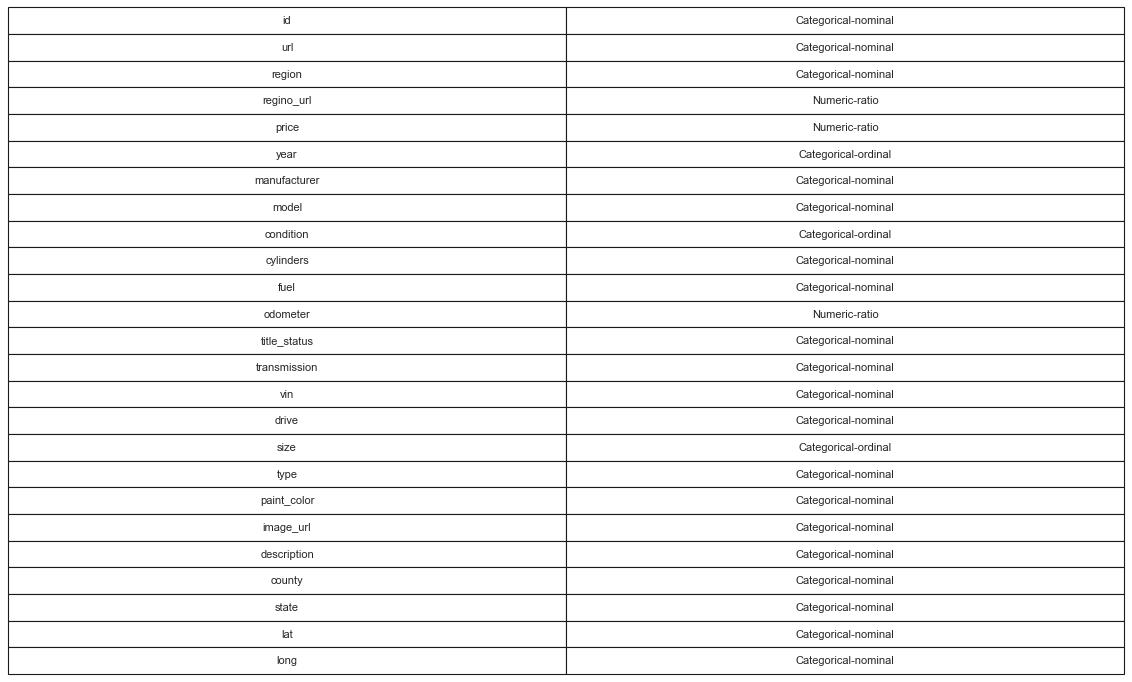

In [ ]:
def feature_types():
    fig = plt.figure(dpi=80)
    ax = fig.add_subplot(1,1,1)

    table_data = [
    ['id','Categorical-nominal'],
    ['url','Categorical-nominal'],
    ['region','Categorical-nominal'],
    ['region_url','Categorical-nominal'],
    ['price','Numeric-ratio'],
    ['year','Categorical-ordinal'],
    ['manufacturer','Categorical-nominal'],
    ['model','Categorical-nominal'],
    ['condition','Categorical-ordinal'],
    ['cylinders','Categorical-nominal'],
    ['fuel','Categorical-nominal'],
    ['odometer','Numeric-ratio'],
    ['title_status','Categorical-nominal'],
    ['transmission','Categorical-nominal'],
    ['vin','Categorical-nominal'],
    ['drive','Categorical-nominal'],
    ['size','Categorical-ordinal'],
    ['type','Categorical-nominal'],
    ['paint_color','Categorical-nominal'],
    ['image_url','Categorical-nominal'],
    ['description','Categorical-nominal'],
    ['county','Categorical-nominal'],
    ['state','Categorical-nominal'],
    ['lat','Categorical-nominal'],
    ['long','Categorical-nominal']
    ]

    table = ax.table(cellText=table_data,cellLoc='center', loc='center')
    table.scale(3,2)
    ax.axis('off')
    plt.rcParams["font.size"] = '13'
    plt.show()
feature_types()


## **A - 2 Veri Setinin Yapisal Olarak Incelenmesi**

Burada veri setini biraz daha detayli inceleyecegiz. Buradan elde edecegimiz sonuclar projemizin devaminda yapacagimiz calismalari planlamak icin bize yol gosterici birer harita rolunu ustlenecektir.

In [ ]:
raw_data.describe().T


,count,mean,std,min,25%,50%,75%,max
id,423857.0,7.190602e+09,5.159269e+06,7.178302e+09,7.186688e+09,7.192068e+09,7.194909e+09,7.197006e+09
price,423857.0,5.779437e+04,1.002581e+07,0.000000e+00,4.499000e+03,9.995000e+03,1.899500e+04,3.808256e+09
year,328743.0,2.009827e+03,1.013581e+01,1.900000e+03,2.007000e+03,2.012000e+03,2.016000e+03,2.021000e+03
odometer,270585.0,9.942578e+04,1.204833e+05,0.000000e+00,4.432400e+04,9.174900e+04,1.372370e+05,1.000000e+07
county,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,324404.0,3.873143e+01,5.902977e+00,-8.038640e+01,3.505450e+01,3.936690e+01,4.251707e+01,8.038340e+01
long,324404.0,-9.394937e+01,1.793057e+01,-1.613940e+02,-1.066780e+02,-8.800990e+01,-8.083250e+01,1.155240e+02


### **A - 2.1 Outlier'larin Gozlemlenmesi**

Uzerinde calismak uzere veri setimizin numerik sutunlarinin outlier icerip icermedigini kontrol ediyor. Bunun icin boxplot tablolama yontemini kullaniyoruz.
    (price,odometer,year)

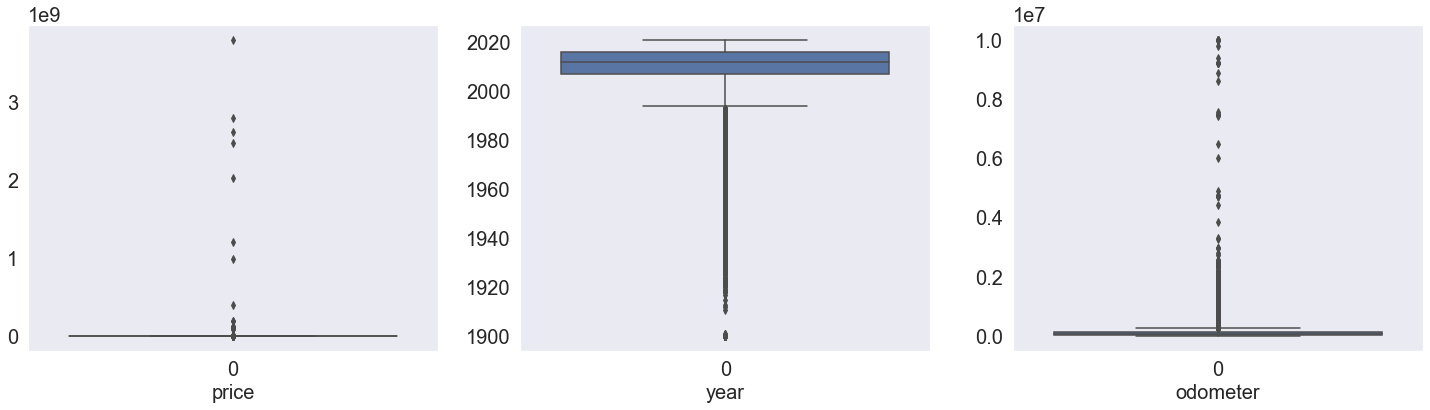

In [ ]:
def outlier_plots():

    f,ax=plt.subplots(1,3,figsize=(25,6))
    sns.boxplot(data=raw_data.price, ax=ax[0]) 
    ax[0].set_xlabel('price',fontsize=20)
    sns.boxplot(data=raw_data.year,ax=ax[1])
    ax[1].set_xlabel('year',fontsize=20)
    sns.boxplot(data=raw_data.odometer, ax=ax[2])
    ax[2].set_xlabel('odometer',fontsize=20)


    plt.show()
outlier_plots()

Boxplotları gözlemlediğimizde, gözlemenen sütunların çok fazla outlier içerdiğini görebiliriz.

### **A - 2.2 Missing Value'larin Gozlemlenmesi**


Verisetinin missing value icerip icermedigini ve iceriyorsa bu missing value'larin dagiliminin ne sekilde oldugunu gozlemledik.

In [ ]:
raw_data.isnull().sum()

id                   0
url                  0
region               0
region_url           0
price                0
year             95114
manufacturer    110615
model            98473
condition       247138
cylinders       226178
fuel             96643
odometer        153272
title_status     96098
transmission     95792
vin             239437
drive           192738
size            321230
type            182700
paint_color     201654
image_url        94196
description      94203
county          423857
state                0
lat              99453
long             99453
dtype: int64

Data setin yapisal butunlugunu gozlemlemek istedigimizde cok fazla missing value(eksik deger) oldugunu gorebiliyoruz. Bu missing value'larin veri seti uzerinde dagilimini asagida yer alan tabloda gozleyebiliriz;

<Figure size 432x288 with 0 Axes>

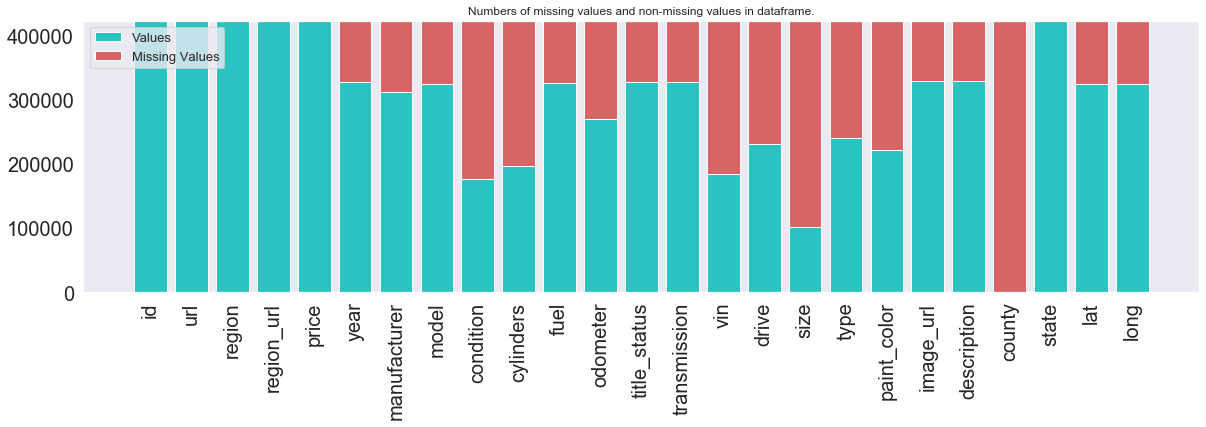

In [ ]:
def missing_bar_chart():
    null_counts = raw_data.isnull().sum()
    value_counts = len(raw_data) - raw_data.isnull().sum()


    fig = plt.figure()
    labels = raw_data.columns
    values = value_counts
    nulls = null_counts


    fig, ax = plt.subplots(figsize=(20,5))
    ax.bar(labels, values, label = 'Values', width=0.8,color = '#2bc2c2')
    ax.bar(labels, nulls, bottom = values, label = 'Missing Values', width=0.8,color = '#d96467')
    ax.set_title('Numbers of missing values and non-missing values in dataframe.')
    ax.legend(loc=2,prop={'size': 13})


    plt.rcParams["font.size"] = '14'
    plt.xticks(rotation=90)

    plt.show()
missing_bar_chart()

Tabloda gozlemlegimiz uzere 'county' sutunu herhangi bir veri tasimamaktadir. Bunun disinda hedef degiskenimiz olacak 'price' sutununun her hangi bir missing value barindirmamaktadir.

Missing Value Yüzde verileri

In [ ]:
all_data_na = (raw_data.isnull().sum() / len(raw_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
county,100.000000
size,75.787353
condition,58.306929
vin,56.490043
cylinders,53.361865
paint_color,47.575951
drive,45.472412
type,43.104160
odometer,36.161252
manufacturer,26.097245


Text(0.5, 1.0, 'Percent missing data by feature')

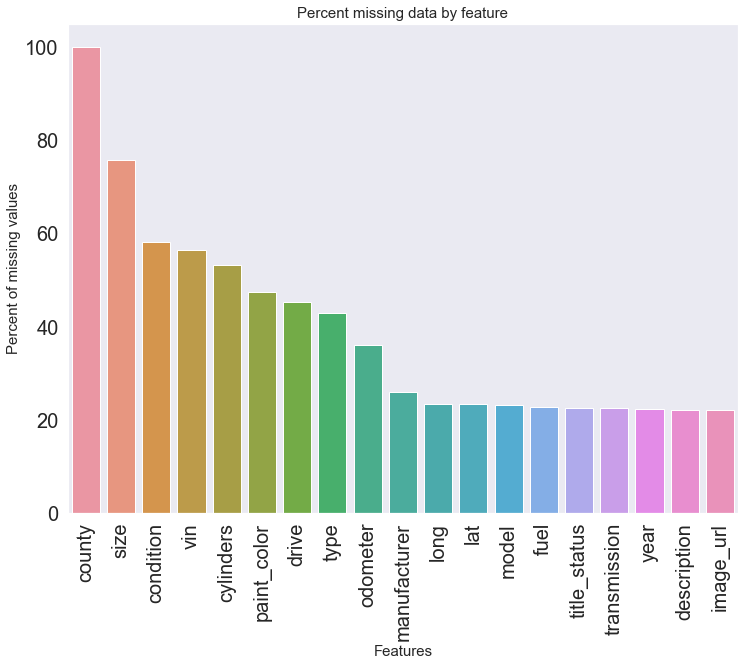

In [ ]:
f, ax = plt.subplots(figsize=(12, 9))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

Veri setimizde yer alan missing valuelarin sebebini gozlemlememiz gerekirse; bu missing valularin kaynak web sitesinin yapisindan kaynakli bir hatadan dolayi olustugunu soyleyebiliyoruz.
Missing valuelar herhangi bir degiskene bagli olarak olusmadigi icin, bu missing value yapisinin MCAR(Missing Completely at Random) oldugunu goruyoruz.

# **B - Veri Setinin Hazirlanmasi**

## **B - 1 Sutunlarin Drop Edilmesi**

In [ ]:
data = raw_data.copy()

In [ ]:
data.drop(columns = ["url", "region_url","image_url", "county","vin","description","lat","long","id"],axis=1,inplace=True)

Sezgisel olarak fiyatlandirma konusunda bize fayda saglamayacagini dusundugumuz sutunlari ve hicbir veri tasimayan county sutununu veri setimizden drop ediyoruz.

## **B - 2 Data Preprocessing**

### **B - 2.1 Data Dropping**

In [ ]:
data = data.drop(data[(data.manufacturer.isna())].index)

In [ ]:
data = data.drop(data[(data.model.isna())].index) 

Manufacturer ve model sütunları MCAR olduğu için sildik.


In [ ]:
data.isnull().sum()

region               0
price                0
year                11
manufacturer         0
model                0
condition       143067
cylinders       121936
fuel              2045
odometer         51350
title_status      1658
transmission      1418
drive            88968
size            212271
type             79680
paint_color      98462
state                0
dtype: int64

In [ ]:
data.shape

(308976, 16)

### **B - 2.2 PRICE OUTLIER CLEANING**

In [ ]:
lower_limit = data["price"].quantile(q=0.1)
upper_limit = data["price"].quantile(q=0.98)
number_of_outliers = len(data[(data["price"] < lower_limit) | (data["price"] > upper_limit)])

print(lower_limit)
print(upper_limit)
f"{number_of_outliers}"

399.0
48988.0


'37036'

In [ ]:
data_index = data[(data["price"] < 399) | (data["price"] > 48988)].index

data.drop(index=data_index,inplace=True)

In [ ]:
data["price"].max()

48988

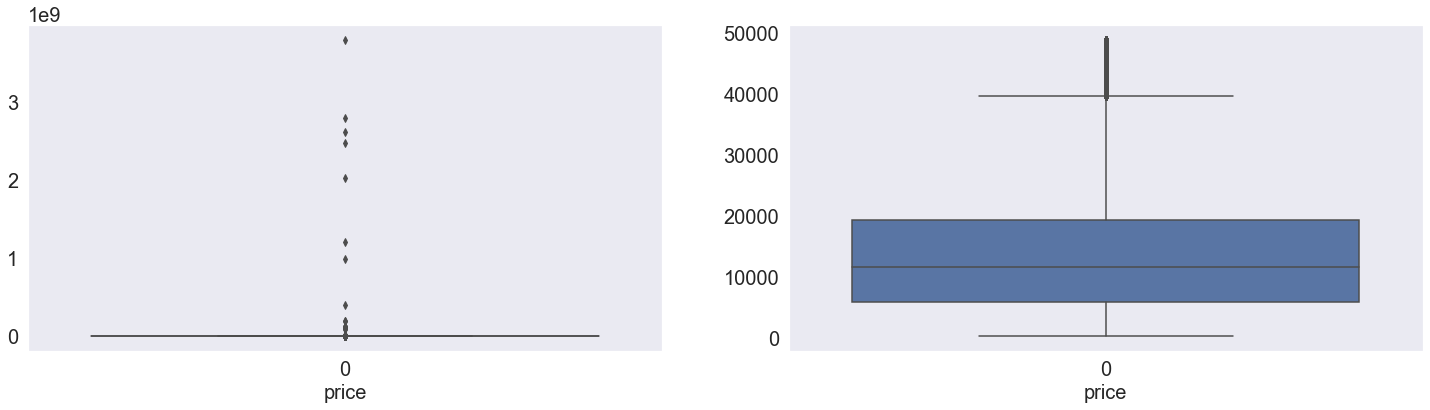

In [ ]:
def price_outlier_plots():

    f,ax=plt.subplots(1,2,figsize=(25,6))
    sns.boxplot(data=raw_data.price, ax=ax[0]) 
    ax[0].set_xlabel('price',fontsize=20)
    sns.boxplot(data=data.price,ax=ax[1])
    ax[1].set_xlabel('price',fontsize=20)



    plt.show()
price_outlier_plots()

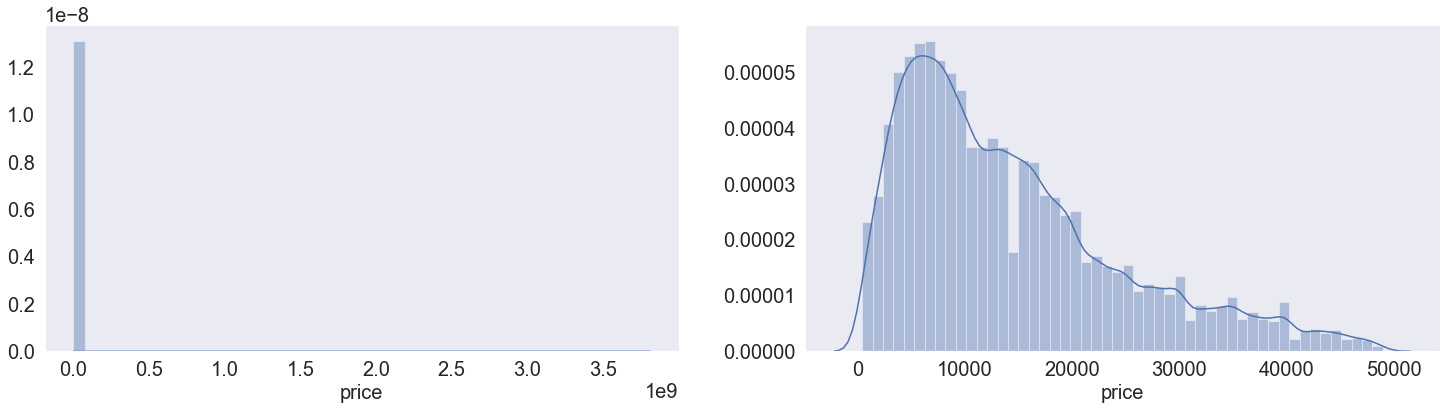

In [ ]:
def price_outlier_dplots():

    f,ax=plt.subplots(1,2,figsize=(25,6))
    sns.distplot(raw_data['price'], ax=ax[0]) 
    ax[0].set_xlabel('price',fontsize=20)
    sns.distplot(data['price'],ax=ax[1])
    ax[1].set_xlabel('price',fontsize=20)



    plt.show()
price_outlier_dplots()

**Hard Edge yöntemi ile outlierlardan kurtulduktan sonra boxplot'ımızın daha az aykırı değer içerdiğini görebiliriz.**

### **B - 2.3 ODOMETER OUTLIER CLEANING**

In [ ]:
low_limit = data["odometer"].quantile(q=0.00)
up_limit = data["odometer"].quantile(q=0.96)
count_of_outliers = len(data[(data["odometer"] < low_limit) | (data["odometer"] > up_limit)])

print(low_limit)
print(up_limit)
f"{count_of_outliers}"

0.0
215500.0


'9121'

In [ ]:
data = data[~((data.odometer < low_limit) | (data.odometer > up_limit))]

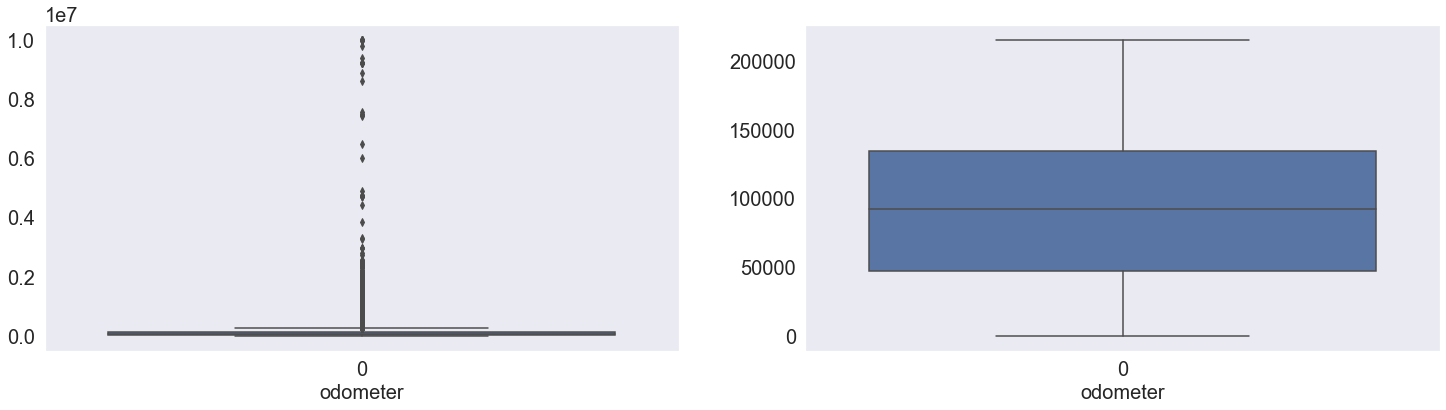

In [ ]:
def odometer_outlier_plots():

    f,ax=plt.subplots(1,2,figsize=(25,6))
    sns.boxplot(data=raw_data.odometer, ax=ax[0]) 
    ax[0].set_xlabel('odometer',fontsize=20)
    sns.boxplot(data=data.odometer,ax=ax[1])
    ax[1].set_xlabel('odometer',fontsize=20)



    plt.show()
odometer_outlier_plots()

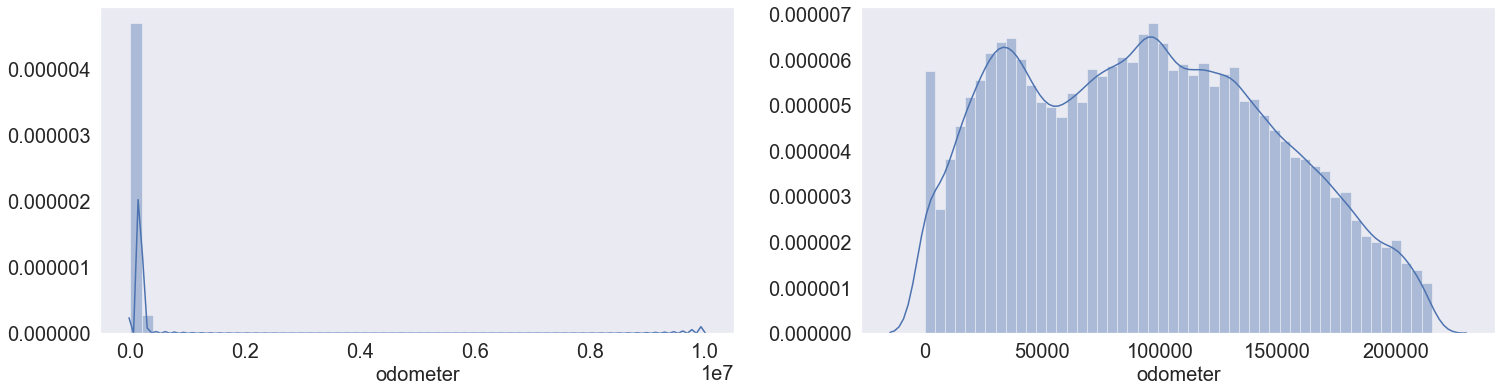

In [ ]:
def odometer_outlier_dplots():

    f,ax=plt.subplots(1,2,figsize=(25,6))
    sns.distplot(raw_data['odometer'], ax=ax[0]) 
    ax[0].set_xlabel('odometer',fontsize=20)
    sns.distplot(data['odometer'],ax=ax[1])
    ax[1].set_xlabel('odometer',fontsize=20)



    plt.show()
odometer_outlier_dplots()

## **B - 2.4 Missing Value Imputation**


Odometer kolonunda missing value olan değerleri doldurmak için bir mantık dengesi kurmaya çalıştık. Bu mantığa göre, dolduracağımız aracın odometer değeri; bu aracın year değerine bakılıp o year değerindeki bütün araçların price ortalamaları elde edilip ve bu price değeri, aracımıza ait price değerinden yüksekse; aracımızın ortalamaya göre biraz daha fazla yol katettiğini ve ortalamadan daha fazla odometer değerine sahip olmasıyla ya da bütün bu denklemin tersine işlemesiyle gerçekleşeceğini düşünüp buna göre odometer doldurmasını gerçekleştirdik.

In [ ]:
data = data.reset_index(drop=True) 

**ODOMETER**

In [ ]:
a = data.groupby('year').odometer.mean()
b = data.groupby('year').price.mean()

In [ ]:
for idx in data.price.index:  # odometer
    p = data.iloc[idx]["price"]
    y = data.iloc[idx]["year"]
    o = data.iloc[idx]["odometer"]
    if np.isnan(o) and (p > b[y]):
        data.at[idx, "odometer"] = a[y] * 0.8
    elif np.isnan(o) and (p < b[y]): 
        data.at[idx,"odometer"] = a[y] * 1.2
    else:
        
        continue

In [ ]:
data.dropna(subset=['odometer'], inplace=True)

In [ ]:
data['odometer'].sort_values(ascending=False)

186246    215500.0
87731     215500.0
69044     215500.0
61412     215500.0
149748    215500.0
            ...   
54323          0.0
54330          0.0
190932         0.0
102251         0.0
184982         0.0
Name: odometer, Length: 262807, dtype: float64

Odometer değerlerini yukarıda kurduğumuz mantığa göre doldurmuş olduk ve ortalamanın da 99425.7 den(missing value doldurmadan önce) 97279.6 ya (missing value doldurduktan sonra) değiştiğini yani çok belirgin bir etki yapmadan doldurduğumuzu gözlemledik.


**TRANSMISSION & FUEL & PAINT_COLOR & TITLE_STATUS**




In [ ]:
data.transmission.value_counts()

automatic    235317
manual        17155
other          9294
Name: transmission, dtype: int64

In [ ]:
data.transmission = data.transmission.fillna(data.transmission.mode()[0])

Çoğunlukla automatic araba olduğu için modla doldurmaya karar verdik. 

In [ ]:
data.fuel.value_counts()

gas         236256
diesel       13337
other         7569
hybrid        3196
electric       729
Name: fuel, dtype: int64

In [ ]:
data.fuel = data.fuel.fillna(data.fuel.mode()[0])

Arabaların çoğunun net bir ağırlıkla fuel olarak gas kullandığını gördük ve mode ile doldurmanın bir probleme yol açmayacağını düşündük.

In [ ]:
data.paint_color.value_counts()

white     44756
black     35851
silver    27633
blue      19296
grey      18391
red       18181
custom     5274
green      4714
brown      3844
yellow     1276
orange     1189
purple      523
Name: paint_color, dtype: int64

In [ ]:
data.paint_color = data.paint_color.fillna(data.paint_color.mode()[0])

Paint Color kolonundaki kayıplar rastgele (MCAR) olduğu için mode ile doldurmayı en iyi yol olarak gördük. 


In [ ]:
data.title_status.value_counts()  # %4 civarı clean değil yani hemen hepsi clean ile dolu. Biz de böyle yapmalıyız mode ile doldurmalıyız.

clean         251028
rebuilt         5444
salvage         2816
lien            1715
missing          395
parts only       107
Name: title_status, dtype: int64

In [ ]:
data.title_status = data.title_status.fillna(data.title_status.mode()[0]) 

Title status kolonuna baktığımızda yaklaşık %96 clean değeri ile dolu, doğal olarak mode ile doldurmayı denedik.

**CONDITION**

Imputer yolunu kullanarak Condition kolonumuzu most_frequent aracılığıyla doldurmuş olduk.

In [ ]:
from sklearn.impute import SimpleImputer 
imp_mode = SimpleImputer(strategy='most_frequent')
imp_mode.fit(data[["condition"]])
data["condition"] = imp_mode.fit_transform(data[["condition"]])

In [ ]:
data = data.drop(data[(data.year.isna())].index) # kalan 5 adet year satırı düşürüldü

## Keşifsel Veri Analizi (Exploratory Data Analysis) - EDA

In [ ]:
eda_df = data.copy()

    Bu bölümde veri setimizin detaylarını grafikler ile anlattık. Değişkenlerin içerdiği veri miktarlarını ve bunlara göre oluşan dağılımlarını bu bölümde açıkladık. 

C:\Users\berke\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


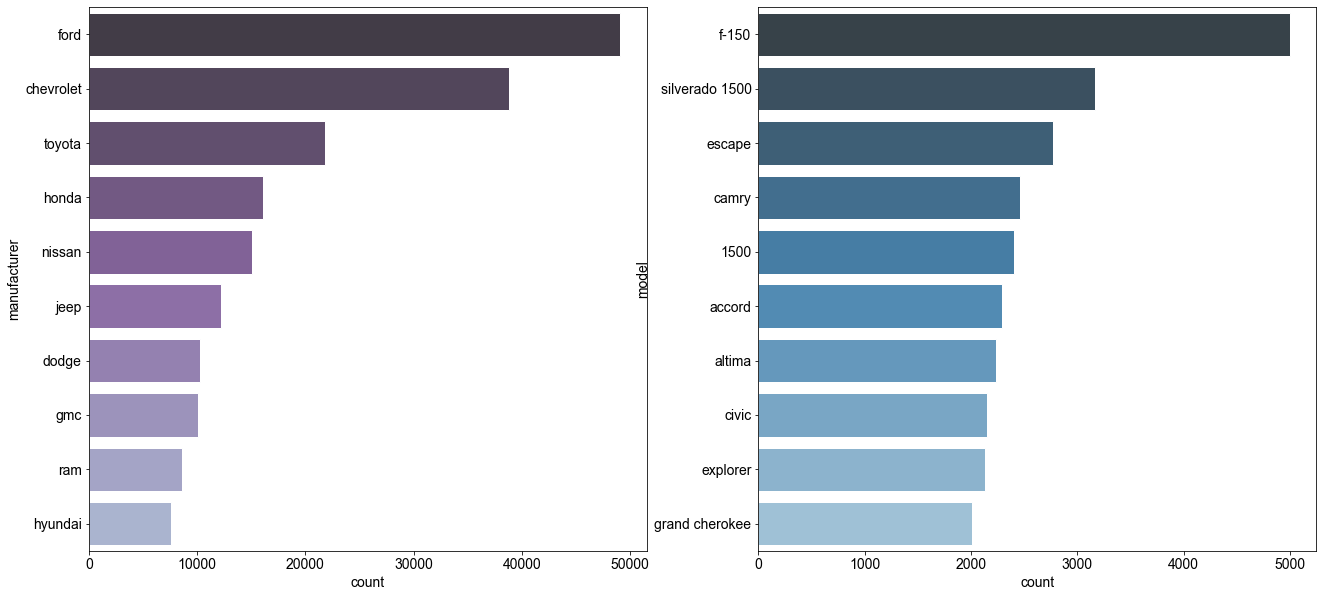

In [ ]:
def count_plot_mm():
    fig, ax =plt.subplots(1,2,figsize=(22, 10),facecolor='white')

    sns.set(rc={"axes.grid":False,'xtick.labelsize':20,'ytick.labelsize':20})
    graph1 = sns.countplot(y ='model',data = eda_df,order=eda_df.model.value_counts().iloc[:10].index, ax = ax[1],palette=('Blues_d')) 
    graph2 = sns.countplot(y ='manufacturer',data = eda_df,order=eda_df.manufacturer.value_counts().iloc[:10].index, ax= ax[0],palette=('BuPu_d'))
    
    plt.rcParams["font.size"] = '14'
    fig.show()
count_plot_mm()

    Yukarıdaki Craiglist.org'da en çok sergilenen ilk on marka ve modeli inceledik.
    Yukarıdaki gözlemleyebileceğimiz üzere; Cragilist.org'da en fazla listelenen araç üreticisi Ford olurken, en çok listelenen araç modeli de yine Ford tarafından üretilen F-150 modeli olduğunu söyleyebiliyoruz.
    Diğer listelenen markaları gözlemlediğimizde, ilan sayısı açısından Ford'un pazarda büyük bir paya sahip olduğunu söyleyebiliriz. 

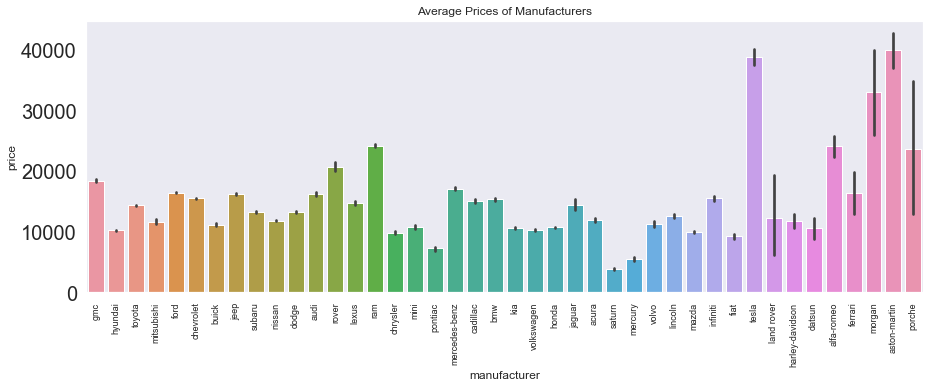

In [ ]:
def mean_price(): 
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x='manufacturer', y='price', data=eda_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=9)
    plt.title("Average Prices of Manufacturers")
mean_price()

    Yukaridakı grafikte araç üreticilerinin ortalama fiyatlarını gözlemledik. Craiglist.org'da yer alan bilgilere göre ortalama fiyatları en yüksek ilk üç markayı sırasıyla Aston-Martin, Tesla ve Morgan olarak gözlemlerken, en düşük ortalama fiyata sahip üç marka ise Saturn, Mercury ve Pontiact olarak gözlemledik.

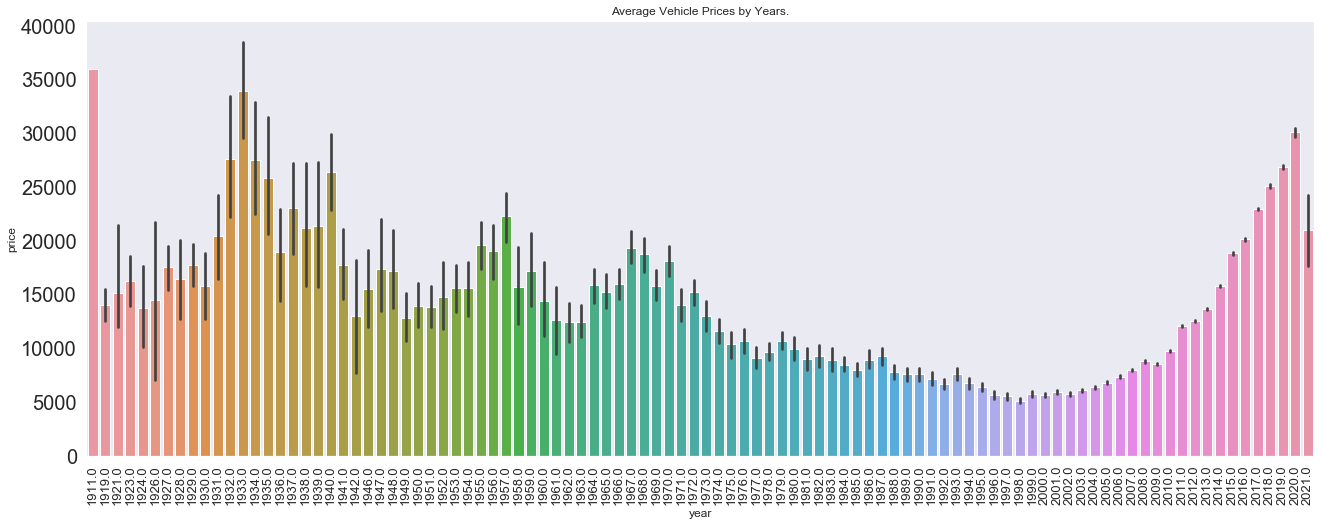

In [ ]:
def mean_year_price():
    plt.figure(figsize=(22,8))
    ax = sns.barplot(x='year', y='price', data=eda_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90,fontsize=13)
    plt.title("Average Vehicle Prices by Years.")
    plt.show()
mean_year_price()

    Yukarıdaki grafikte elimizdeki verilere göre yıllık ortalama araç fiyatlarını gözlemledik. Yukarıdaki grafiğe göre fiyat ortalamalarından yola çıkarak, grafiği üç parçadan oluşan bir bütün olarak değerlendirdik.
    Bunlardan ilki Antika(Klasik) olarak değerlendirdiğimiz bir grup. Bu grubun en belirgin özelliğine gelecek olursak lineer bir artış veya düşüş gözlemleyemiyor olmamız. Fiyat ortalamalarının yüksek seviyede olmasına karşın belirli bir düzenden bahsedemiyoruz. 
    İkinci grup olarak orta sınıf olarak tanımlayabileceğimiz 1970-2000 yılları arasında üretilen araçlar var. Burada lineere çok yakın bir düşüş gözlemliyoruz. Antika(Klasik) araçlardan çıkıp 'Yeni Jenerasyon' olarak tanımlayacağız gruba varan bir süreçten bahsedebiliriz. Ortalama fiyat olarak en düşük değerlere sahip grup olarak da burayı söyleyebiliriz.
    Üçüncü grup olarak 'Yeni Jenerasyon' olarak tanımladığımız bir grup var. Buraya geldiğimizde araçlar, Antika(Klasik) olarak değerlendiğimiz araçlardan tamamen ayrılmış ve günümüze doğru ortalama fiyatlar lineer bir şekilde artmış olduğunu gözlemliyoruz.

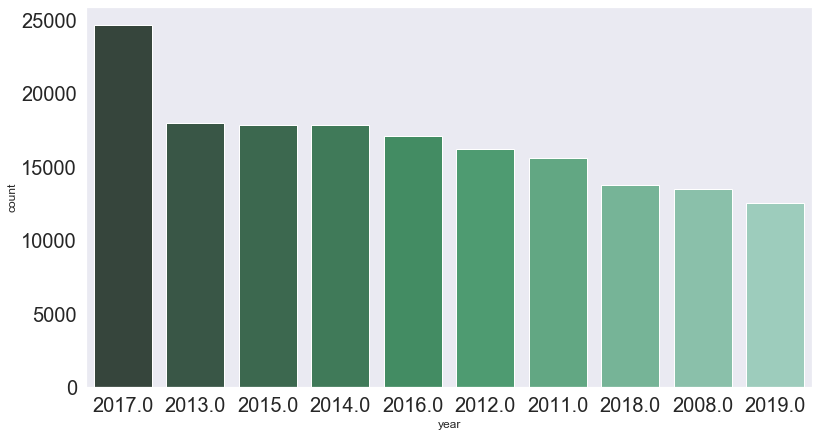

In [ ]:
def year_countplot():
    plt.figure(figsize=(13,7))
    sns.countplot(x ='year',data = eda_df,order=eda_df.year.value_counts().iloc[:10].index,palette=('BuGn_d')) 
year_countplot()

    Bu grafikte araçların üretim tarihine göre en çok ilan adedi bulunduran ilk on yılı gözlemledik. Bu grafiğe göre, bir önceki grafikte tanımladığımız 'Yeni Jenerasyon' grubunun ilan sayısında da zirvede olduğunu söyleyebiliriz.

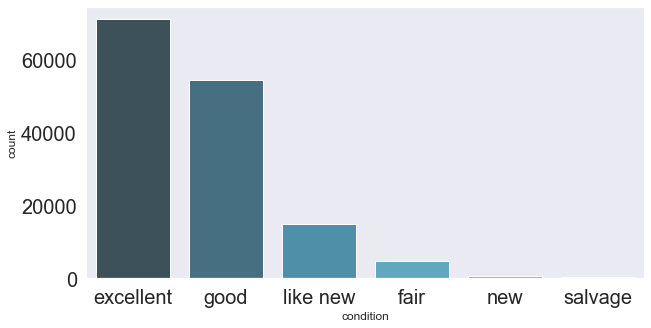

In [ ]:
def condition_countplot():
    plt.figure(figsize=(10,5))
    sns.countplot(x = 'condition',
              data = eda_df,
              order = eda_df['condition'].value_counts().index,palette=('GnBu_d'))
condition_countplot()

        Yukarıdaki grafikte araçların kondisyon değerlerinin ilan sayısı üzerindeki dağılımı görüyoruz. Excellent(mükemmel) durumdaki araç sayısının diğer durumlara oranla ciddi bir üstünlük kurduğunu söyleyebiliriz. 

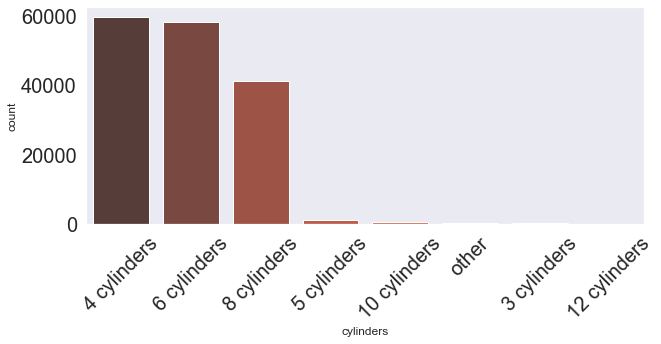

In [ ]:
def cylinders_countplot():
    plt.figure(figsize=(10,4))
    countplot = sns.countplot(x = 'cylinders',
              data = eda_df,
              order = eda_df['cylinders'].value_counts().index,palette=('OrRd_d'))
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=45)
cylinders_countplot()

    Yukarıdaki grafikte sahip olduğu silindir sayılarına göre gruplandırılan araç ilanlarının, toplam ilan adedi üzerinde dağılımını görüyoruz. Dört, sekiz ve altı silindire sahip araç ilanlarının diğerlerine göre büyük oranda fazla olduğunu söyleyebiliriz.

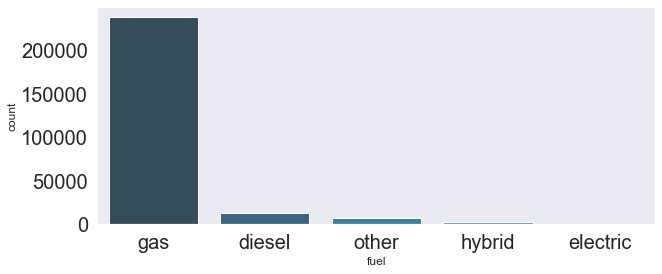

In [ ]:
def fuel_countplot():
    plt.figure(figsize=(10,4))
    sns.countplot(x = 'fuel',
              data = eda_df,
              order = eda_df['fuel'].value_counts().index,palette=('PuBu_d'))
fuel_countplot()

    Yukarıdaki grafikte yakıt türlerine göre araç ilanlarının, toplam ilan adedi üzerinde dağılımını görüyoruz. Bu grafikte gas(benzin) yakıtını kullanan açal ilanlarının diğerlerine oranla çok yüksek bir sayıda olduğunu söyleyebiliriz. 

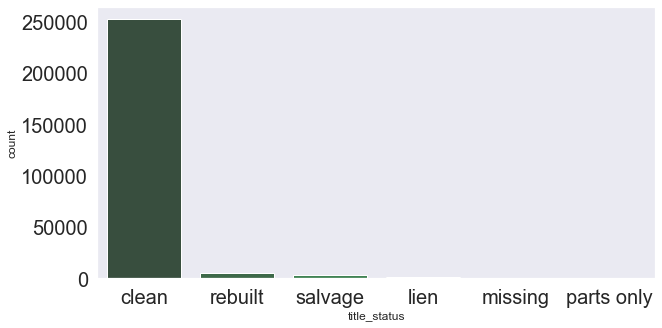

In [ ]:
def title_status_countplot():
    plt.figure(figsize=(10,5))
    sns.countplot(x = 'title_status',
              data = eda_df,
              order = eda_df['title_status'].value_counts().index,palette=('YlGn_d'))
title_status_countplot()

        Yukarıdaki grafikte sahip ilan başıklarına(aracın durumu) göre gruplandırılan araç ilanların, toplam ilan adedi üzerinde dağılımını görüyoruz. Clean(temiz) olarak değerlendirilen araç ilanlarının sayısının neredeyse ilan sayısı ile eşdeğer olduğunu görüyoruz. Diğer durumlara göre çok büyük farkla en tepede yer alıyor.

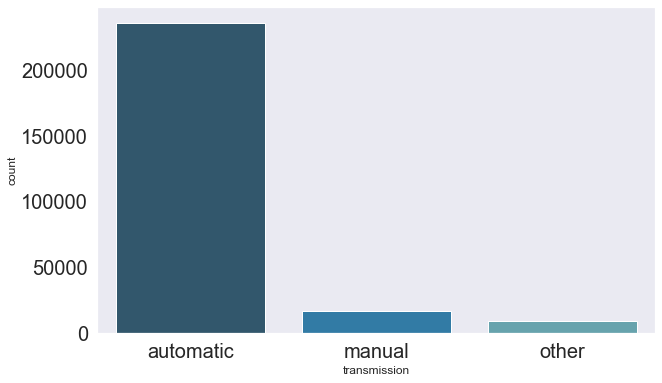

In [ ]:
def transmission_countplot():
    plt.figure(figsize=(10,6))
    sns.countplot(x = 'transmission',
              data = eda_df,
              order = eda_df['transmission'].value_counts().index,palette=('YlGnBu_d'))
transmission_countplot()

    Yukarıdaki grafikte vites türlerine göre gruplandırılan araç ilanlarının, toplam ilan adedi üzerinde dağılımını görüyoruz. Automatic(otomatik) vites türüne sahip araç ilanlarının diğerlerine kurduğu büyük bir üstünlükten bahsedebiliriz.
    Bağımsız kuruluşlardan edindiğimiz bilgiye göre ABD'de otomatik vites en çok kullanılan vites türü. Bu grafikte, bu bilgiyi doğrular bir dağılım olduğunu görüyoruz.

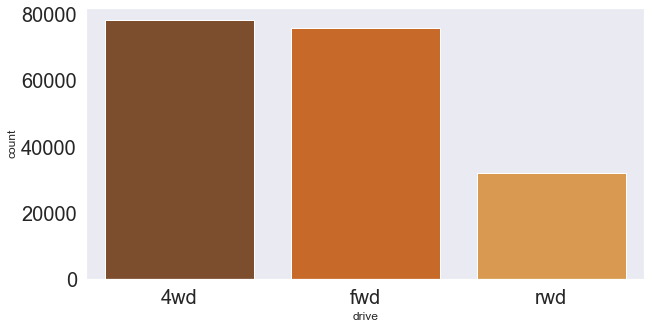

In [ ]:
def drive_countplot():
    plt.figure(figsize=(10,5))
    sns.countplot(x = 'drive',
              data = eda_df,
              order = eda_df['drive'].value_counts().index,palette=('YlOrBr_d'))
drive_countplot()

     Yukarıdaki grafikte araçların şanzuman aktarma sistemine göre gruplanlarılan araç ilanlarının, toplam ilan adedi üzerindeki dağılımını gözlemliyoruz. Buna göre, 4wd(dört çeker) ve fwd(önden çekişli) araçların ilan sayısının birbirine çok yakın ve rwd(arkadan itişli) araçların ilan sayısına göre büyük oranda yukarıda olduğunu söyleyebiliriz.

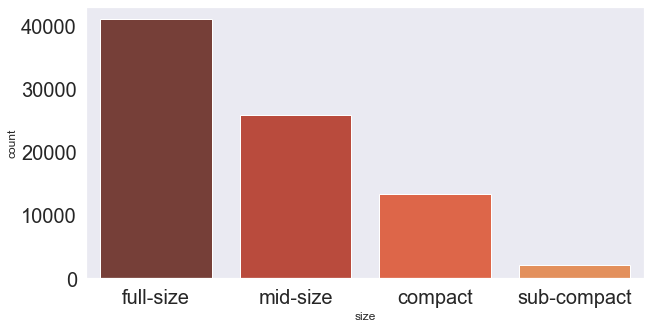

In [ ]:
def size_countplot():
    plt.figure(figsize=(10,5))
    sns.countplot(x = 'size',
              data = eda_df,
              order = eda_df['size'].value_counts().index,palette=('YlOrRd_d'))
size_countplot()

        Yukarıdaki grafikte araç boyutlarına göre gruplandırılmış araç ilanlarının, toplam ilan adeti üzerindeki dağılımını görüyoruz. full-size olarak değerlendirilen araçların pazarda büyük bir çoğunluğa sahip olduğunu söyleyebiliriz. Aşağıdaki grafik ise bunu doğrular nitelikte bilgiler vermektedir;

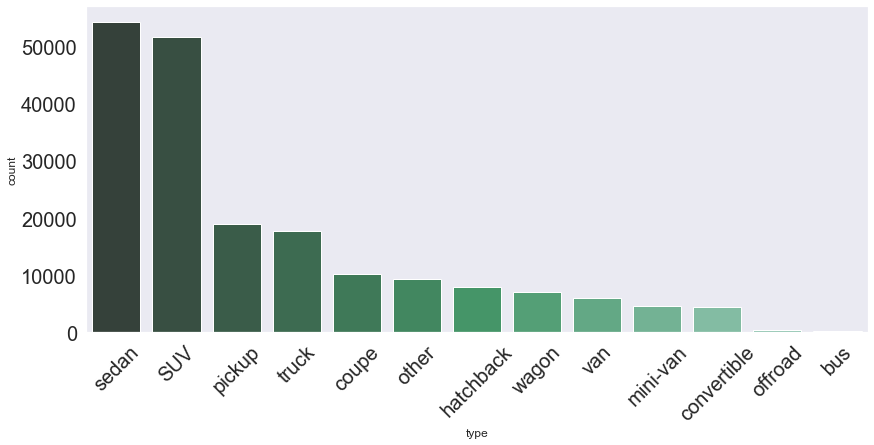

In [ ]:
def type_countplot():
    plt.figure(figsize=(14,6))
    countplot = sns.countplot(x = 'type',
              data = eda_df,
              order = eda_df['type'].value_counts().index,palette=('BuGn_d'))
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=45)
type_countplot()

    Burada araçların türlerine göre sınıflandırılmış araç ilanlarının, toplam ilan adetine göre dağılımını görüyoruz. Yukarıdaki grafik ile beraber değerlendirildiği zaman full-size kategorisine giren SUV, Pickup ve Truck araç türlenin ilk dörtte konumlandığını görebiliriz. Bu bilgi de bir üstteki grafiğin doğrulanmasında bize yardımcı oluyor.

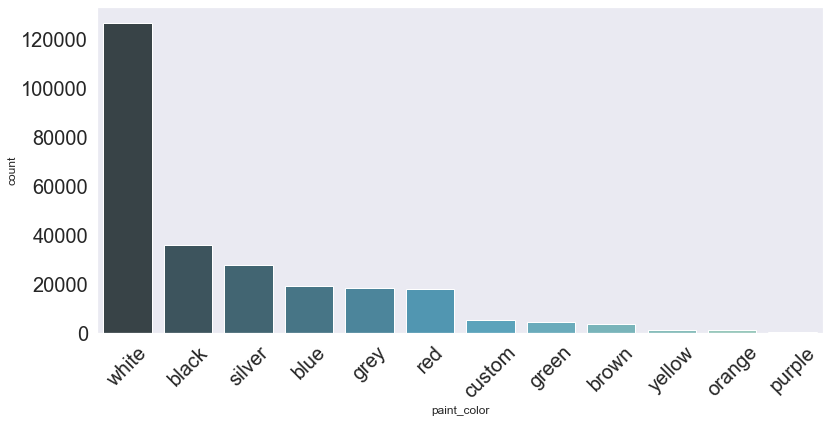

In [ ]:
def paintcolor_countplot():
    plt.figure(figsize=(13,6))
    countplot = sns.countplot(x = 'paint_color',
              data = eda_df,
              order = eda_df['paint_color'].value_counts().index,palette=('GnBu_d'))
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=45)
paintcolor_countplot()

    Burada araçların renklerine göre gruplandırılmış araç ilanlarının, toplam ilan adeti üzerindeki dağılımını görüyoruz. Büyük bir üstünlükle white(beyaz) renkteki araçlar için girilen ilanların, diğerlerine göre yukarıda olduğunu söyleyebiliriz.

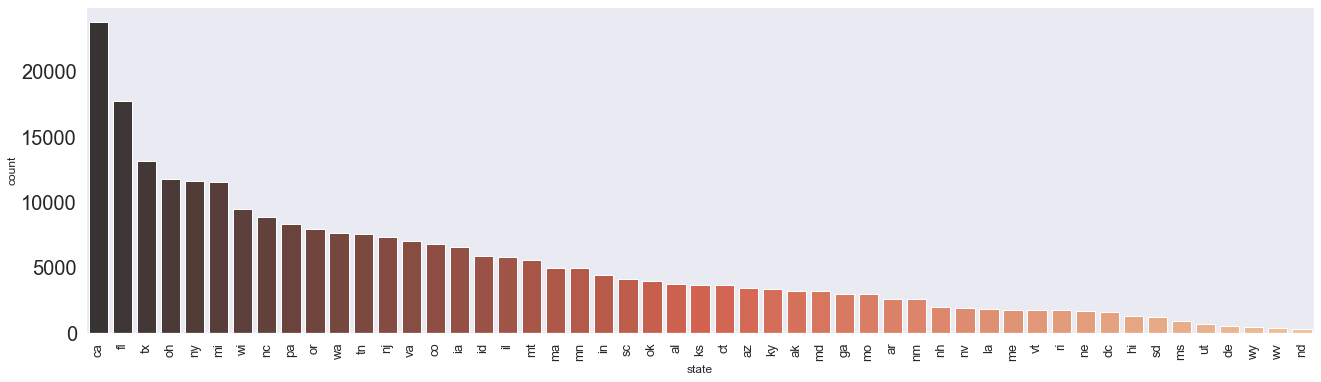

In [ ]:
def state_countplot():
    plt.figure(figsize=(22,6))
    countplot = sns.countplot(x = 'state',
              data = eda_df,
              order = eda_df['state'].value_counts().index,palette=('OrRd_d'))
    countplot.set_xticklabels(countplot.get_xticklabels(), rotation=90, fontsize=13)
state_countplot()

    Burada araç ilanının verildiği eyalete göre araç ilanlarının, toplam ilan adeti üzerindeki dağılımını görüyoruz. Bu grafikte ABD'de eyalet nüfüslarında ilk onda olan ca(Kaliforniya), fl(Florida), tx(Teksas), oh(Ohio) ve ny(New York) eyaletlerinin girilen ilan adetinde de ilk beş sırada yer aldığını görebiliyoruz. Bu bilgiden nüfusun fazla olduğu eyaletlerde oluşturulan araç ilanlarının, diğerlerine kıyasla daha fazla olduğunu söyleyebiliriz.

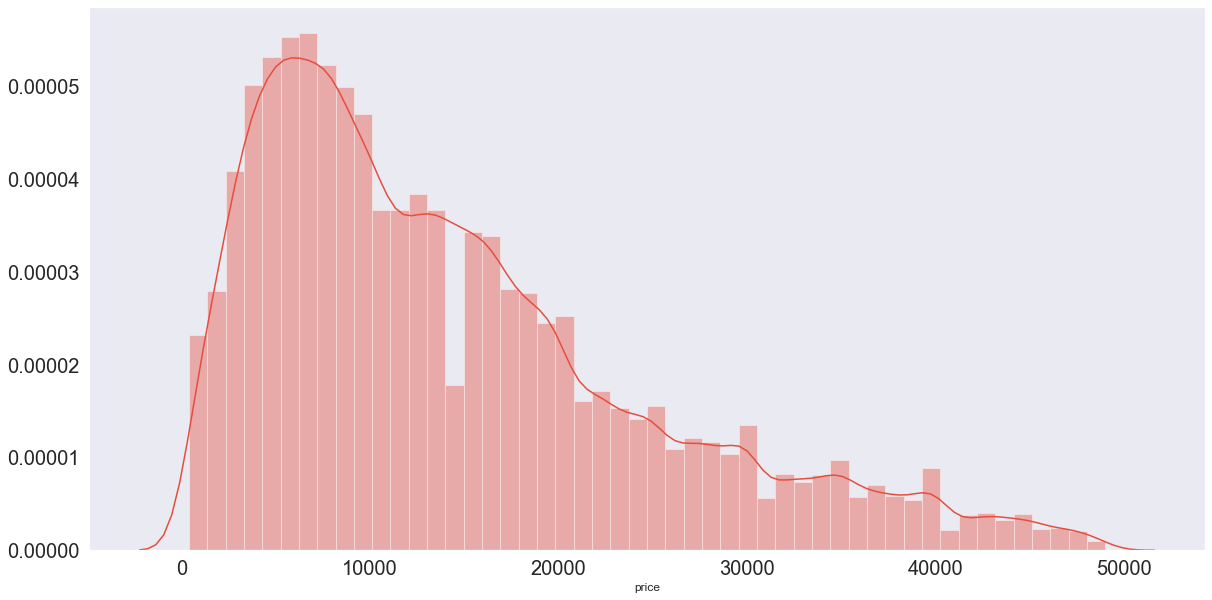

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(eda_df.price, color='#e74c3c')

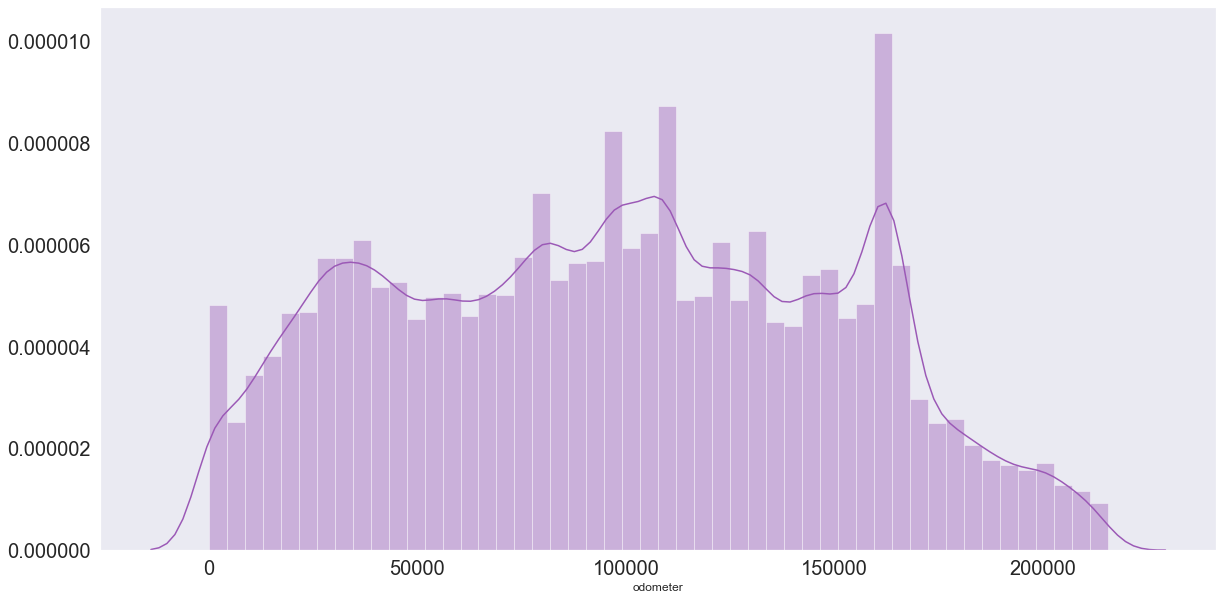

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(eda_df.odometer, color='#9b59b6')

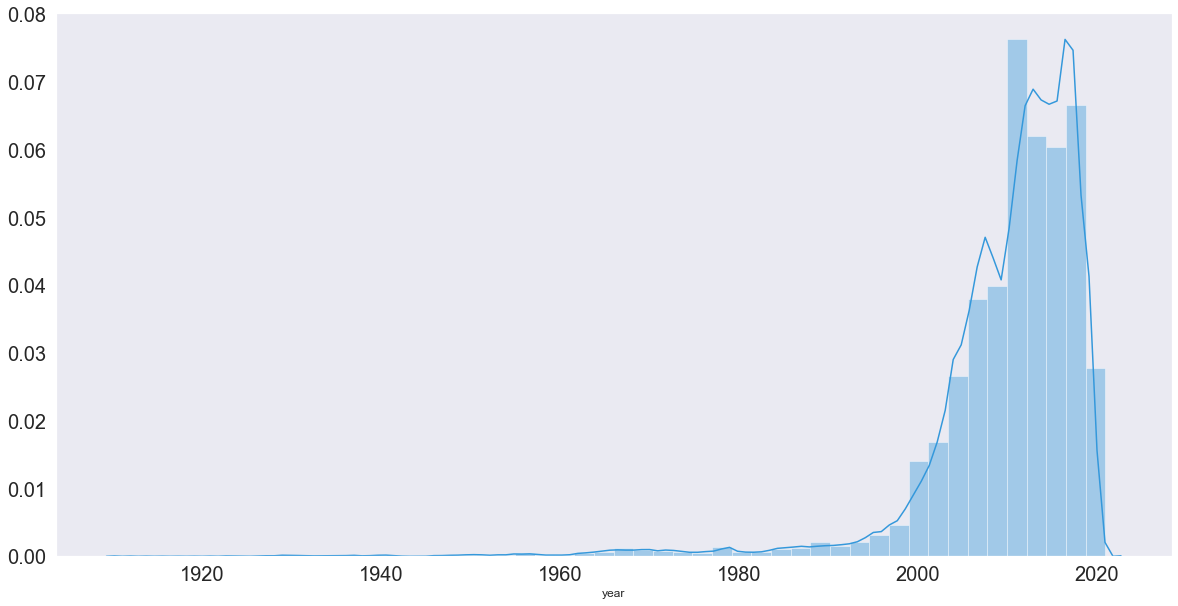

In [ ]:
plt.figure(figsize=(20,10))
sns.distplot(eda_df.year, color='#3498db')

## **B - 3 Encoding and  Iterative(Model Based) Imputation**


### **B - 3.1 Label and Ordinal Encoding**



*   **LABEL ENCODING** : Manufacturer, Model, Cylinders, Size, Type, Fuel, Title_status, Transmission, State, Region, Paint_color
*   ORDINAL ENCODING : Condition



LABEL ENCODING

In [ ]:
df = data.copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

df_label = data.copy()

In [ ]:
df_label = df_label[['cylinders','size','type','drive']]

In [ ]:
enc = LabelEncoder()

In [ ]:
encoders = dict()  # NAN olan sütunlar encoding yapılmadı

for col_name in df_label.columns:
    series = df_label[col_name]
    enc = LabelEncoder()
    df_label[col_name] = pd.Series(
        enc.fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    )
    encoders[col_name] = enc

print(df_label)

        cylinders  size  type  drive
0             6.0   NaN   NaN    0.0
1             3.0   NaN   NaN    1.0
2             3.0   NaN   NaN    1.0
3             3.0   2.0   9.0    0.0
4             5.0   1.0  10.0    0.0
...           ...   ...   ...    ...
262814        5.0   NaN   9.0    1.0
262815        6.0   1.0   0.0    0.0
262816        5.0   NaN   NaN    2.0
262817        6.0   NaN   9.0    2.0
262818        NaN   0.0   9.0    1.0

[262803 rows x 4 columns]


In [ ]:
df['manufacturer'] = df['manufacturer'].astype('str')
df['model'] = df['model'].astype('str')
df['fuel'] = df['fuel'].astype('str')
df['title_status'] = df['title_status'].astype('str')
df['transmission'] = df['transmission'].astype('str')
df['state'] = df['state'].astype('str')
df['region'] = df['region'].astype('str')
df['paint_color'] = df['paint_color'].astype('str')

In [ ]:
# It is not recommended to use the same label encoder for all the features in the data set. 
#It is safe to create a label encoder for each column because each feature varies in terms of the values.
le_manufacturer = LabelEncoder()
le_model = LabelEncoder()
le_fuel = LabelEncoder()
le_status = LabelEncoder()
le_transmission = LabelEncoder()
le_state = LabelEncoder()
le_region = LabelEncoder()
le_paint = LabelEncoder()

In [ ]:
from sklearn.preprocessing import LabelEncoder
df["manufacturer"] = le_manufacturer.fit_transform(df["manufacturer"])
df['model'] = le_model.fit_transform(df['model'])
df["fuel"] = le_fuel.fit_transform(df['fuel'])
df["title_status"] = le_status.fit_transform(df['title_status'])
df["transmission"] = le_transmission.fit_transform(df['transmission'])
df["state"] = le_state.fit_transform(df['state'])
df["region"] = le_region.fit_transform(df['region'])
df["paint_color"] = le_paint.fit_transform(df['paint_color'])

ORDINAL ENCODING

In [ ]:
mapping = {
    "new" : 6,
    "like new" : 5,
    "excellent" : 4,
    "good" : 3,
    "fair" : 2,
    "salvage" : 1
}

df['condition'] = df['condition'].map(mapping)
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,84,6995,2000.0,14,12131,4,8 cylinders,2,167783.000000,0,0,4wd,NaN,NaN,8,23
1,84,8750,2013.0,17,15516,4,4 cylinders,2,90821.000000,0,0,fwd,NaN,NaN,5,23
2,231,10900,2013.0,39,12953,3,4 cylinders,3,92800.000000,0,0,fwd,NaN,NaN,1,6
3,3,12500,2003.0,29,10763,3,4 cylinders,2,110533.190517,0,1,4wd,mid-size,sedan,5,32
4,84,13995,2012.0,13,7344,3,6 cylinders,2,188406.000000,0,0,4wd,full-size,truck,5,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262814,84,1600,2006.0,17,15516,2,6 cylinders,2,159980.000000,0,0,fwd,NaN,sedan,1,23
262815,84,9000,2003.0,39,14609,4,8 cylinders,2,160000.000000,0,0,4wd,full-size,SUV,4,23
262816,84,700,1994.0,13,7344,2,6 cylinders,2,212000.000000,0,1,rwd,NaN,NaN,4,23
262817,84,3800,1999.0,24,16837,4,8 cylinders,2,160000.000000,0,0,rwd,NaN,sedan,10,23


### **B - 3.2 ITERATIVE (MODEL-BASED) IMPUTATION**

cylinders, drive, size ve type featureları, manufacturer ve model'e bağlı oldukları için model ile doldurulmaya karar verildi

**Model(Random Forest) ile doldurulacak feature'lar**

*   cylinders
*   drive
*   size
*   type


**CYLINDERS**

In [ ]:
df['cylinders'] = df_label['cylinders']

In [ ]:
dataWithcylinders = df[pd.isnull(df['cylinders']) == False]
dataWithoutcylinders = df[pd.isnull(df['cylinders'])]

In [ ]:
independentVariables = ['price','year', 'manufacturer','model']

rfModel_cylinders = RandomForestClassifier(random_state=42)
rfModel_cylinders.fit(dataWithcylinders[independentVariables], dataWithcylinders['cylinders'])

generatedCylinderValues = rfModel_cylinders.predict(X = dataWithoutcylinders[independentVariables])

In [ ]:
generatedCylinderValues

array([6., 6., 5., ..., 5., 6., 3.])

In [ ]:
dataWithoutcylinders['cylinders'] = generatedCylinderValues.astype(float)
df = dataWithcylinders.append(dataWithoutcylinders)

C:\Users\berke\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**TYPE**

In [ ]:
df['type'] = df_label['type']

In [ ]:
dataWithtype = df[pd.isnull(df['type']) == False]
dataWithouttype = df[pd.isnull(df['type'])]

In [ ]:
independentVariables_2 = ['price','year','manufacturer','model','cylinders']

rfModel_type = RandomForestClassifier(random_state=42)
rfModel_type.fit(dataWithtype[independentVariables_2], dataWithtype['type'])

generatedTypeValues = rfModel_type.predict(X = dataWithouttype[independentVariables_2])

In [ ]:
dataWithouttype['type'] = generatedTypeValues.astype(float)
df = dataWithtype.append(dataWithouttype)

C:\Users\berke\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
generatedTypeValues


array([10.,  9.,  4., ...,  0.,  9.,  0.])

**SIZE**

In [ ]:
df['size'] = df_label['size']
dataWithsize = df[pd.isnull(df['size']) == False]
dataWithoutsize = df[pd.isnull(df['size'])]

In [ ]:
independentVariables_3 = ['price','year','manufacturer','model','cylinders','type']

rfModel_size = RandomForestClassifier(random_state=42)
rfModel_size.fit(dataWithsize[independentVariables_3], dataWithsize['size'])

generatedSizeValues = rfModel_size.predict(X = dataWithoutsize[independentVariables_3])

In [ ]:
dataWithoutsize['size'] = generatedSizeValues.astype(float)
df = dataWithsize.append(dataWithoutsize)

C:\Users\berke\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**DRIVE**

In [ ]:
df['drive'] = df_label['drive']

In [ ]:
dataWithdrive = df[pd.isnull(df['drive']) == False]
dataWithoutdrive = df[pd.isnull(df['drive'])]

In [ ]:
independentVariables = ['region','price','year', 'manufacturer','model','fuel','transmission']

rfModel_drive = RandomForestClassifier(random_state=42)
rfModel_drive.fit(dataWithdrive[independentVariables], dataWithdrive['drive'])

generatedDriveValues = rfModel_drive.predict(X = dataWithoutdrive[independentVariables])

In [ ]:
generatedDriveValues

array([0., 1., 0., ..., 0., 1., 1.])

In [ ]:
dataWithoutdrive['drive'] = generatedDriveValues.astype(float)
df = dataWithdrive.append(dataWithoutdrive)

C:\Users\berke\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**MODEL BASED IMPUTATION RESULTS**

In [ ]:
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
3,3,12500,2003.0,29,10763,3,3.0,2,110533.190517,0,1,0.0,2.0,9.0,5,32
4,84,13995,2012.0,13,7344,3,5.0,2,188406.000000,0,0,0.0,1.0,10.0,5,23
5,84,7995,2010.0,7,6674,3,3.0,2,108124.000000,0,0,0.0,1.0,0.0,5,23
6,84,8995,2011.0,7,17084,3,5.0,2,178054.000000,0,0,0.0,1.0,0.0,10,23
7,84,10995,2014.0,13,7084,3,5.0,2,170259.000000,0,0,0.0,1.0,0.0,10,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262758,84,9999,2012.0,37,8837,4,3.0,2,101820.000000,0,0,0.0,2.0,0.0,0,23
262767,84,3500,2010.0,27,11616,4,5.0,2,148012.817857,0,0,1.0,2.0,9.0,10,23
262770,84,1200,2005.0,16,12848,4,5.0,2,162464.970240,0,0,0.0,1.0,0.0,10,23
262774,3,4200,2003.0,16,2254,4,3.0,2,165799.785775,0,0,1.0,2.0,9.0,10,32


In [ ]:
df.isnull().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

## **B - 4 Scaling**

### **B - 4 .1 StandardScaler for odometer**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df_scale = df.copy()

In [ ]:
df_scale['odometer']=df_scale['odometer'].fillna(value=1.0).astype(int)    

In [ ]:
scaler=MinMaxScaler(feature_range=(0,10))

In [ ]:
df_scale["odometer"] = scaler.fit_transform(df_scale["odometer"].values.reshape(-1,1)).astype(int)

In [ ]:
df_scale

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
3,3,12500,2003.0,29,10763,3,3.0,2,5,0,1,0.0,2.0,9.0,5,32
4,84,13995,2012.0,13,7344,3,5.0,2,8,0,0,0.0,1.0,10.0,5,23
5,84,7995,2010.0,7,6674,3,3.0,2,5,0,0,0.0,1.0,0.0,5,23
6,84,8995,2011.0,7,17084,3,5.0,2,8,0,0,0.0,1.0,0.0,10,23
7,84,10995,2014.0,13,7084,3,5.0,2,7,0,0,0.0,1.0,0.0,10,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262758,84,9999,2012.0,37,8837,4,3.0,2,4,0,0,0.0,2.0,0.0,0,23
262767,84,3500,2010.0,27,11616,4,5.0,2,6,0,0,1.0,2.0,9.0,10,23
262770,84,1200,2005.0,16,12848,4,5.0,2,7,0,0,0.0,1.0,0.0,10,23
262774,3,4200,2003.0,16,2254,4,3.0,2,7,0,0,1.0,2.0,9.0,10,32


In [ ]:
df["odometer"] = df_scale["odometer"]

In [ ]:
df.reset_index(drop=True)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,3,12500,2003.0,29,10763,3,3.0,2,5,0,1,0.0,2.0,9.0,5,32
1,84,13995,2012.0,13,7344,3,5.0,2,8,0,0,0.0,1.0,10.0,5,23
2,84,7995,2010.0,7,6674,3,3.0,2,5,0,0,0.0,1.0,0.0,5,23
3,84,8995,2011.0,7,17084,3,5.0,2,8,0,0,0.0,1.0,0.0,10,23
4,84,10995,2014.0,13,7084,3,5.0,2,7,0,0,0.0,1.0,0.0,10,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262798,84,9999,2012.0,37,8837,4,3.0,2,4,0,0,0.0,2.0,0.0,0,23
262799,84,3500,2010.0,27,11616,4,5.0,2,6,0,0,1.0,2.0,9.0,10,23
262800,84,1200,2005.0,16,12848,4,5.0,2,7,0,0,0.0,1.0,0.0,10,23
262801,3,4200,2003.0,16,2254,4,3.0,2,7,0,0,1.0,2.0,9.0,10,32


## **B - 5 TARGET FEATURE**

In [ ]:
series_x, bins = pd.cut(data.price, bins=6, retbins=True, labels=[0,1,2,3,4,5])
series_x.value_counts()

0    93524
1    81060
2    44563
3    22786
4    14643
5     6227
Name: price, dtype: int64

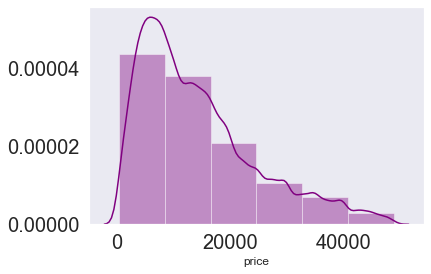

In [ ]:
sns.distplot(df["price"], color='purple',bins=bins)

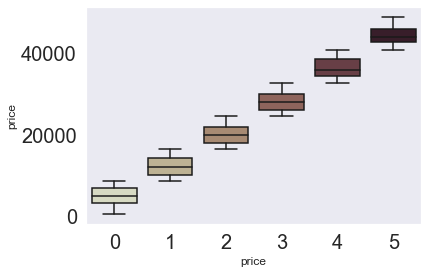

In [ ]:
sns.boxplot(x = series_x , y = data["price"], palette="ch:0.5")

In [ ]:
bins = [398,8000,16000,24000,32000,40000,49000]
group_names = ['398-8000', '8000-16000', '16000-24000', '24000-32000','32000-40000','40000-48989']
df.loc[:,'price'] = pd.cut(df.price, bins, labels=group_names)

In [ ]:
df["price"].value_counts()

398-8000       91462
8000-16000     80850
16000-24000    46024
24000-32000    23062
32000-40000    15017
40000-48989     6388
Name: price, dtype: int64

In [ ]:
#PRICE KATEGORİK HALE GETİRİLDİ 

# **C - MODELING**

## **C - 1 Train Test Split**

In [ ]:
y = df.price
X = df.drop(["price"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [ ]:
X_train.dtypes

region            int32
year            float64
manufacturer      int32
model             int32
condition         int64
cylinders       float64
fuel              int32
odometer          int32
title_status      int32
transmission      int32
drive           float64
size            float64
type            float64
paint_color       int32
state             int32
dtype: object

In [ ]:
y_train.dtypes

CategoricalDtype(categories=['398-8000', '8000-16000', '16000-24000', '24000-32000',
                  '32000-40000', '40000-48989'],
                 ordered=True)

## **C - 2 Models**

### **C - 2.1 XGBOOST**

In [ ]:
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=350,
                    max_depth=10,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=6,
                    seed=27)
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)


In [ ]:
accuracy_score(y_test, y_pred)

0.8421789622684587

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
recall=recall_score(y_test,y_pred,average='weighted')
precision=precision_score(y_test,y_pred,average='weighted')

In [ ]:
print('\n','Recall : '+str(recall))
print('\n','Precision : '+str(precision))


 Recall : 0.8421789622684587

 Precision : 0.8420297986172574


**FEATURE IMPORTANCE**

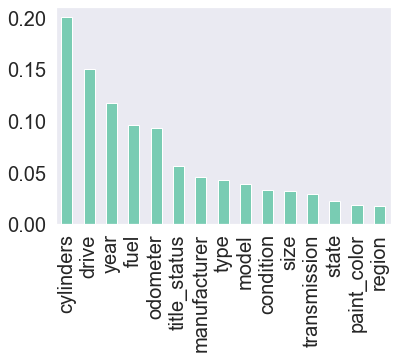

In [ ]:
features = X_train.columns 
importances = xgb.feature_importances_
indices = np.argsort(importances)
feat_importances_xg = pd.Series(importances, index=features)
feat_importances_xg.nlargest(len(indices)).plot(kind='bar',color = '#79CCB3');

### **C - 2.2 RANDOM FOREST**

In [ ]:
rf_model = RandomForestClassifier(n_estimators=350, criterion='gini',max_depth=15, max_features='auto', random_state=42) #grid search sonuçlarına göre en iyi seçeneklere göre ayarlandı

In [ ]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7772636641755833

FEATURE IMPORTANCE

In [ ]:
features = X_train.columns 
importances = rf_model.feature_importances_
indices = np.argsort(importances)

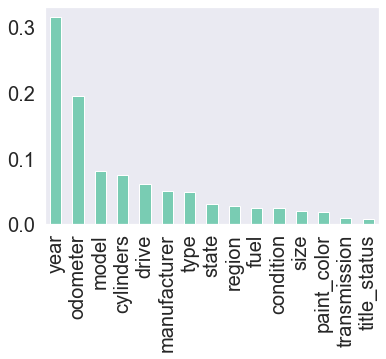

In [ ]:
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(len(indices)).plot(kind='bar',color = '#79CCB3');

### **C - 2.3 DECISION TREE**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.7843564024900687

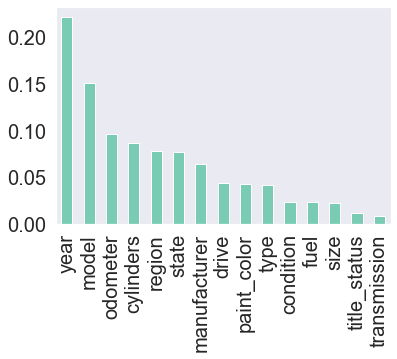

In [ ]:
features = X_train.columns 
importances = dt.feature_importances_
indices = np.argsort(importances)
feat_importances_dt = pd.Series(importances, index=features)
feat_importances_dt.nlargest(len(indices)).plot(kind='bar',color = '#79CCB3');

### **C - 2.4 GRADIENT BOOSTING**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_clf = GradientBoostingClassifier(n_estimators=350, learning_rate=0.1,
                                                   max_depth=7, random_state=42).fit(X_train, y_train)

y_pred = gradient_boosting_clf.predict(X_test)


In [ ]:
accuracy_score(y_test, y_pred)

0.8197592121885512

FEATURE IMPORTANCE

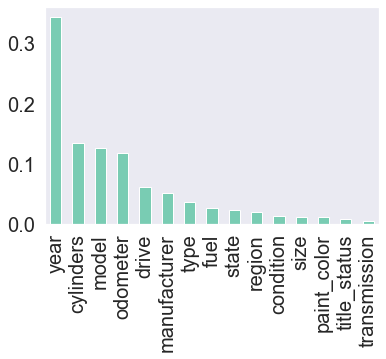

In [ ]:
features = X_train.columns 
importances = gradient_boosting_clf.feature_importances_
indices = np.argsort(importances)
feat_importances = pd.Series(importances, index=features)
plt.rcParams["font.size"] = '19'
feat_importances.nlargest(len(indices)).plot(kind='bar',color = '#79CCB3');  

## **C - 3 MODEL EVALUATION**


### **C - 3.1 ACCURACY METRICS**

*   Accuracy
*   Recall
*   Precision
*   F1 Score




In [ ]:
modeller = [dt,rf_model,xgb,gradient_boosting_clf]
for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)
    recall=recall_score(y_test,y_pred,average='weighted')
    precision=precision_score(y_test,y_pred,average='weighted')
    f1_score= 2*(recall*precision) / (recall + precision)
    
    print("-"*28)
    print(isimler + ":" )
    print("\nAccuracy: {:.4%}".format(dogruluk))
    print('\n','Recall : '+str(recall))
    print('\n','Precision : '+str(precision))
    print('\n','F1 Score : '+str(f1_score))

----------------------------
DecisionTreeClassifier:

Accuracy: 78.4356%

 Recall : 0.7843564024900687

 Precision : 0.7846373196979167

 F1 Score : 0.784496835945875
----------------------------
RandomForestClassifier:

Accuracy: 77.7264%

 Recall : 0.7772636641755833

 Precision : 0.7780069107289493

 F1 Score : 0.7776351098576253
----------------------------
XGBClassifier:

Accuracy: 84.2179%

 Recall : 0.8421789622684587

 Precision : 0.8420297986172574

 F1 Score : 0.8421043738374432
----------------------------
GradientBoostingClassifier:

Accuracy: 81.9759%

 Recall : 0.8197592121885512

 Precision : 0.8196707232904644

 F1 Score : 0.8197149653513957


**ACCURACY - MODEL**

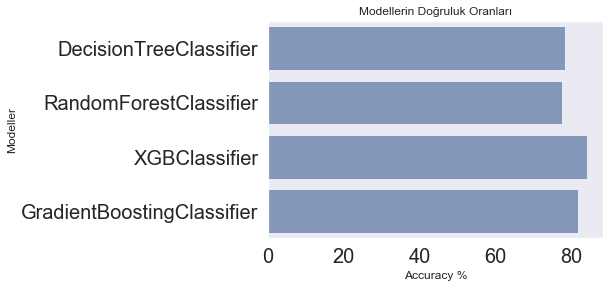

In [ ]:
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Accuracy"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)
    sonuc = pd.DataFrame([[isimler, dogruluk*100]], columns= ["Modeller","Accuracy"])
    sonuclar = sonuclar.append(sonuc)


sns.barplot(x= 'Accuracy', y = 'Modeller', data=sonuclar, color="b", alpha = 0.7)
plt.xlabel('Accuracy %')
plt.title('Modellerin Doğruluk Oranları');

**PRECISION**

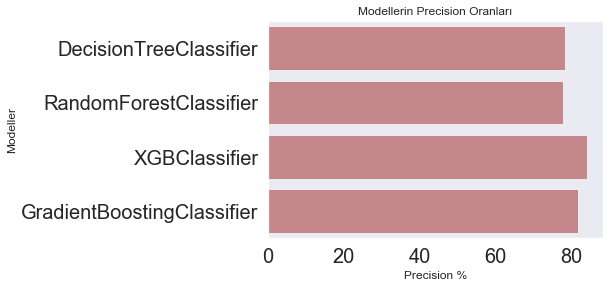

In [ ]:
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Precision"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    precision=precision_score(y_test,y_pred,average='weighted')
    sonuc = pd.DataFrame([[isimler, precision*100]], columns= ["Modeller","Precision"])
    sonuclar = sonuclar.append(sonuc)


sns.barplot(x= 'Precision', y = 'Modeller', data=sonuclar, color="r", alpha = 0.7)
plt.xlabel('Precision %')
plt.title('Modellerin Precision Oranları');

RECALL

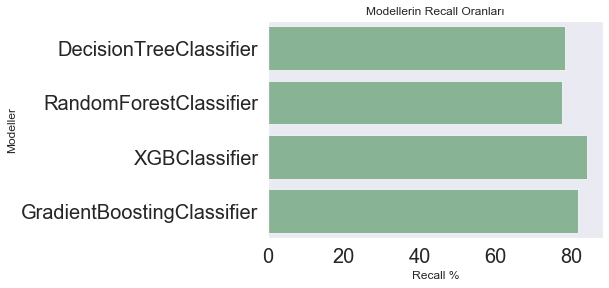

In [ ]:
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","Recall"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    recall=recall_score(y_test,y_pred,average='weighted')
    sonuc = pd.DataFrame([[isimler, recall*100]], columns= ["Modeller","Recall"])
    sonuclar = sonuclar.append(sonuc)


sns.barplot(x= 'Recall', y = 'Modeller', data=sonuclar, color="g", alpha = 0.7)
plt.xlabel('Recall %')
plt.title('Modellerin Recall Oranları');

**F1 SCORE**

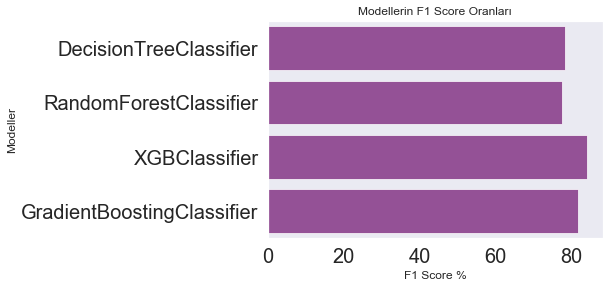

In [ ]:
sonuc = []

sonuclar = pd.DataFrame(columns= ["Modeller","F1 Score"])

for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    recall=recall_score(y_test,y_pred,average='weighted')
    precision=precision_score(y_test,y_pred,average='weighted')
    f1_score = 2*(recall*precision) / (recall + precision)
    sonuc = pd.DataFrame([[isimler, f1_score*100]], columns= ["Modeller","F1 Score"])
    sonuclar = sonuclar.append(sonuc)


sns.barplot(x= 'F1 Score', y = 'Modeller', data=sonuclar, color="purple", alpha = 0.7)
plt.xlabel('F1 Score %')
plt.title('Modellerin F1 Score Oranları');

### **C - 3.2 HYPERPARAMETER TUNING & CROSS VALIDATION**


**DECISION TREE**

In [ ]:
accuracies = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = 10)
print("Accuracy:{:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation:{:.2f} %".format(accuracies.std()*100))

Accuracy:77.83 %
Standard Deviation:0.29 %


**RANDOM FOREST HYPERPARAMETER TUNING**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
model = RandomForestClassifier(n_jobs=-1)

In [ ]:
params = {
    'n_estimators'      : range(100,500,50),
    'max_depth'         : [8, 9, 10, 11, 12],
    'max_features': ['auto'],
    'criterion' :['gini']
}
#metric : f1_micro
gsearch1 = GridSearchCV(estimator = model, param_grid = params, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 198 out of 200 | elapsed: 2

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

In [ ]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [ ]:
getTrainScores(gsearch1)

({0: "mean:0.6551582242766172params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}",
  1: "mean:0.6558736040049838params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 150}",
  2: "mean:0.6547371399897329params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}",
  3: "mean:0.6563606602321521params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 250}",
  4: "mean:0.6558177808712623params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 300}",
  5: "mean:0.6557822781309428params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 350}",
  6: "mean:0.6564012506964233params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 400}",
  7: "mean:0.6563708069794806params{'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 450}",
  8: "mean:0.673580183377628params{'crit

**XGBOOST HYPERPARAMETER TUNING**

In [ ]:
param_test1 = {
 'max_depth':[5,10],
 'n_estimators': [350,500]
}
#metrics: f1_micro
gsearch2 = GridSearchCV(estimator = xgb, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch2.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:  8.0min remaining: 45.4min
C:\Users\berke\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed: 11.0min remaining: 25.6min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed: 14.6min remaining: 17.9min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed: 22.1min remaining: 14.7min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed: 24.9min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 30.1min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 30.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=350, n_jobs=4, n...
                                     num_class=6, num_parallel_tree=1,
                                     objective='multi:softprob',
                                     random_state=27, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=None, seed=27,
                                

In [ ]:
getTrainScores(gsearch2)

({0: "mean:0.763371251941359params{'max_depth': 5, 'n_estimators': 350}",
  1: "mean:0.7752737170646581params{'max_depth': 5, 'n_estimators': 500}",
  2: "mean:0.8343548189829623params{'max_depth': 10, 'n_estimators': 350}",
  3: "mean:0.8382462083612087params{'max_depth': 10, 'n_estimators': 500}"},
 {'best_mean': 0.8382462083612087,
  'best_param': {'max_depth': 10, 'n_estimators': 500}})

**GRADIENT BOOSTING HYPERPARAMETER TUNING**

In [ ]:
param_test3 = {
 'max_depth':[5,10],
 'n_estimators': [100,500]
}
#metric: f1_micro
gsearch3 = GridSearchCV(estimator = gradient_boosting_clf , param_grid = param_test3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch3.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed: 10.3min remaining: 58.4min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed: 25.9min remaining: 60.5min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed: 31.9min remaining: 39.0min
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed: 46.5min remaining: 31.0min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed: 49.0min remaining: 16.3min
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed: 87.4min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 89.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=7,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=350,
                                                  n_iter_no_change=None,
         

In [ ]:
getTrainScores(gsearch3)

({0: "mean:0.7355277911595819params{'max_depth': 5, 'n_estimators': 100}",
  1: "mean:0.789413607864246params{'max_depth': 5, 'n_estimators': 500}",
  2: "mean:0.8260799054132001params{'max_depth': 10, 'n_estimators': 100}",
  3: "mean:0.8432994239253994params{'max_depth': 10, 'n_estimators': 500}"},
 {'best_mean': 0.8432994239253994,
  'best_param': {'max_depth': 10, 'n_estimators': 500}})